In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import spacy
nlp = spacy.load('en_vectors_web_lg')

In [3]:
RECORDS = -1  # -1 means 'load all'
MAX_WORDS_IN_SENTENCE = 200

In [4]:
from src import IMDBDataSet
from IPython.display import display

train = IMDBDataSet.load_data('../data/aclImdb/train', limit=RECORDS)
test = IMDBDataSet.load_data('../data/aclImdb/test', limit=RECORDS)
display(train.head())
display(test.head())

Using TensorFlow backend.


,scores,text
3,1,"b""Dan Katzir has produced a wonderful film tha..."
4,1,b'If you want Scream or anything like the big-...
9,0,"b""Outlandish premise that rates low on plausib..."
11,0,b'Let\'s face it-- if you rented a STDVD seque...
12,0,b'Bizarre Tobe Hooper exercise regarding an un...


,scores,text
0,1,"b""Don't hate Heather Graham because she's beau..."
1,0,b'I don\'t know how this movie has received so...
2,1,"b""I caught this movie on the Horror Channel an..."
3,0,b'NBC had a chance to make a powerful religiou...
4,0,"b""Looking for something shocking? Okay fine......"


count    25000.000000
mean       233.776720
std        173.715418
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: text, dtype: float64

Text(0,0.5,'Count')

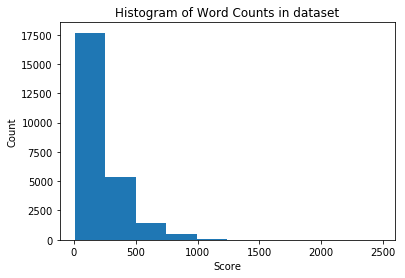

In [5]:
word_counts = train.text.apply(lambda t: len(t.split()))
display(word_counts.describe())
plt.hist(word_counts)
plt.title('Histogram of Word Counts in dataset')
plt.xlabel('Score')
plt.ylabel('Count')

Text(0,0.5,'Count')

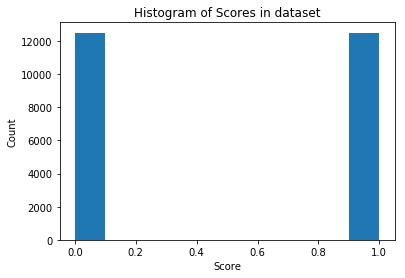

In [6]:
plt.hist(train.scores)
plt.title('Histogram of Scores in dataset')
plt.xlabel('Score')
plt.ylabel('Count')

Text(0,0.5,'Count')

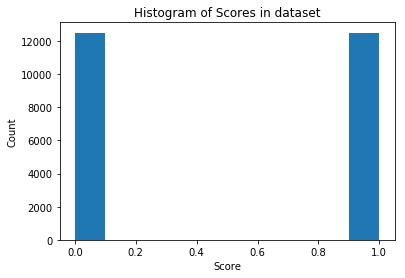

In [7]:
plt.hist(test.scores)
plt.title('Histogram of Scores in dataset')
plt.xlabel('Score')
plt.ylabel('Count')

In [14]:
from src import apply_middlewares, middleware


def apply_common_middleware(dataset, padding_length=200):
    clear_text_middleware = middleware.ClearTextMiddleware()
    binarize_labels_middleware = middleware.BinarizeLabelsMiddleware(threshold=3)
    nlp_middleware = middleware.WordsToNlpIndexMiddleware(nlp)
    input_middleware = middleware.NlpIndexToInputVectorMiddleware(nlp, padding_length=padding_length)
    cache_middleware = middleware.CacheMiddleware('../dist/data')

    return apply_middlewares(dataset, [
        clear_text_middleware,
        binarize_labels_middleware,
        nlp_middleware,
        cache_middleware,
        input_middleware
    ])


# middleware for data processing, caching etc
train_with_middleware = apply_common_middleware(train, padding_length=MAX_WORDS_IN_SENTENCE)
test_with_middleware = apply_common_middleware(test, padding_length=MAX_WORDS_IN_SENTENCE)


n_train_batches, train_generator = train_with_middleware.to_generator(batch_size=128)
n_test_batches, test_generator = test_with_middleware.to_generator(batch_size=128)

In [9]:
from keras.layers import Dense, Conv1D, BatchNormalization, GlobalMaxPooling1D, \
    Activation, Dropout, MaxPooling1D, Input, concatenate
from keras.models import Sequential 
from keras.regularizers import l2

def build_conv1d(max_len=MAX_WORDS_IN_SENTENCE, embedding_dim=300, filters=32, kernel_size=5, l2_weight=0.001,
                 dropout_rate=0.7):
    model = Sequential([
        Conv1D(
            filters, kernel_size, strides=1, kernel_regularizer=l2(l2_weight),
            input_shape=(max_len, embedding_dim), padding='valid', activation='relu'),
        MaxPooling1D(5),
        BatchNormalization(),
        Conv1D(
            2 * filters, kernel_size, strides=1, kernel_regularizer=l2(l2_weight),
            input_shape=(max_len, embedding_dim), padding='valid', activation='relu'),
        GlobalMaxPooling1D(),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, kernel_regularizer=l2(l2_weight)),
    ])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
model = build_conv1d()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 196, 32)           48032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 32)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 64)            10304     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [15]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=n_train_batches,
    epochs=5,
    verbose=1,
    validation_data=test_generator,
    validation_steps=n_test_batches)

Epoch 1/5
Data loaded from data_6895568a.h5
196/196 [==============================] - 23s 117ms/step - loss: 3.6083 - acc: 0.2509 - val_loss: 0.1623 - val_acc: 0.9630
Epoch 2/5
196/196 [==============================] - 16s 84ms/step - loss: 0.7017 - acc: 0.5595 - val_loss: 0.1223 - val_acc: 0.9996
Epoch 3/5
196/196 [==============================] - 16s 84ms/step - loss: 0.2013 - acc: 0.9001 - val_loss: 0.1064 - val_acc: 1.0000
Epoch 4/5
196/196 [==============================] - 17s 86ms/step - loss: 0.1156 - acc: 0.9976 - val_loss: 0.1021 - val_acc: 1.0000
Epoch 5/5
196/196 [==============================] - 17s 89ms/step - loss: 0.1022 - acc: 1.0000 - val_loss: 0.1000 - val_acc: 1.0000


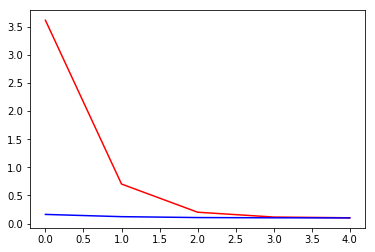

In [17]:
plt.plot(history.history['loss'], c='red')
plt.plot(history.history['val_loss'], c='blue')

In [18]:
model.save('../dist/models/model_conv1d_imdb.h5')

In [20]:
data, labels = test_with_middleware.get_data_and_labels(batch_slice=slice(0, 5))

In [24]:
model.predict(data[:1])

array([[-0.00095111]], dtype=float32)